In [ ]:
# 필요 라이브러리
import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
import pandas as pd

In [ ]:
!pip install konlpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 448 kB 52.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
import tempfile

In [ ]:
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly i

In [ ]:
df = pd.read_excel('review_token.xlsx')

In [ ]:
df = df[['name', 'separate_review', 'sentiment']]
df

,name,separate_review,sentiment
0,호텔 더 디자이너스 홍대,스탠더드 더블 이용 사진에 보이는 창문 앞 욕조가 있는 방을 원했는데 랜덤 배정되...,1
1,호텔 더 디자이너스 홍대,스탠더드 더블 이용 사진에 보이는 창문 앞 욕조가 있는 방을 원했는데 랜덤 배정되...,1
2,호텔 더 디자이너스 홍대,음에 예약할 땐 반드시 전화로 문의해야 할 거 같,1
3,호텔 더 디자이너스 홍대,그 외에는 이불에 머리카락 몇 개 있었던 거랑 세면대 수도관 흔들리는 거 빼고 ...,1
4,호텔 더 디자이너스 홍대,3성급 스위트라고 하기에는 욕실이 좁고 수건이 부족하네요 또 시설이 노후화돼서 여기...,0
...,...,...,...
12653,노보텔 앰배서더 동대문 호텔 & 레지던스,일단 룸 전체가 넓고 화장실도 넓고 다 좋았,1
12654,노보텔 앰배서더 동대문 호텔 & 레지던스,방에 지니로 음악도 듣고 호캉스 제대로 하고 갑니다 직원분들도 한 분 한 분 다 ...,1
12655,노보텔 앰배서더 동대문 호텔 & 레지던스,호텔 3시 체크인인데 2시간이나 대기하다가 체크인하고 그리고 직원이 제대로 키나 룸...,1
12656,노보텔 앰배서더 동대문 호텔 & 레지던스,호텔 3시 체크인인데 2시간이나 대기하다가 체크인하고,1


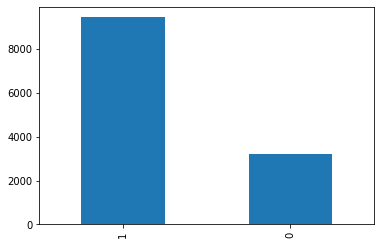

In [ ]:
df['sentiment'].value_counts().plot(kind = 'bar');

In [ ]:
# 긍정부정 라벨링으로 descending order로 분류해 재정렬하기 -> 나중에 stratify를 사용해 긍정과 부정의 비율을 맞추기 위함
df = df.sort_values(by='sentiment', ascending=False)

# 인덱스 재조정
df = df.reset_index()

# 예전 인덱스 칼럼 드랍
df = df.drop(['index'], axis=1)

# 데이터프레임 카피본
labeled_df = df.copy()

In [ ]:
labeled_df

,name,separate_review,sentiment
0,호텔 더 디자이너스 홍대,스탠더드 더블 이용 사진에 보이는 창문 앞 욕조가 있는 방을 원했는데 랜덤 배정되...,1
1,신라스테이 광화문,1층에 스타벅스가 있어서 따로 조식 안 먹었어요 어디든 가기 편한 위치라 아이랑 둘...,1
2,신라스테이 광화문,서비스나 친절은 그냥 평범한 정도였고요 침대 푹신해서 좋았는데 침대 옆에 왕 먼지 ...,1
3,신라스테이 광화문,서비스나 친절은 그냥 평범한 정도였고요 침대 푹신해서 좋았는데 침대 옆에 왕 먼지 ...,1
4,신라스테이 광화문,시내 근접성 좋고 조식도 훌륭했음 객실은 다소 좁습니다,1
...,...,...,...
12653,뜨랑블루 호텔,연방했는데 청소하시면서 저희 짐까지 다 치워버리셨더라고요 당황스러웠습니다 프런트에 ...,0
12654,명동 티마크 그랜드 호텔,남산 경치 잘 보이고 좋,0
12655,명동 티마크 그랜드 호텔,남산 경치 잘 보이고 좋아요 다만 창문이 조금은 더러워서 깔끔 한 맛은 좀 떨어지네요,0
12656,명동 티마크 그랜드 호텔,사람이 많아서 엘베가 잘 안 왔고 욕조 물이 잘 내려가서 샤워할 때 불편했어요,0


# 데이터셋 나누기

In [ ]:
# train | test 데이터로 분리  
train_data, test_data = train_test_split(labeled_df, test_size=0.3, shuffle=True, stratify=labeled_df['sentiment'], random_state=50)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 8860
테스트용 리뷰의 개수 : 3798


# 긍정 라벨링 1, 부정 라벨링 0 의 분포 확인
- 한 클래스가 다른 클래스보다 훨씬 많은 불균형 데이터 셋

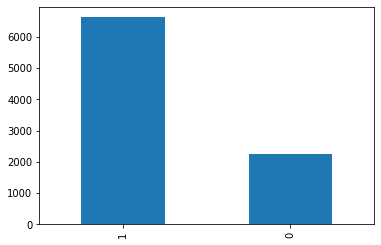

In [ ]:
train_data['sentiment'].value_counts().plot(kind = 'bar');

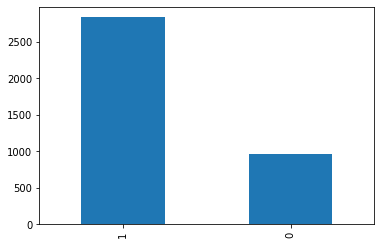

In [ ]:
test_data['sentiment'].value_counts().plot(kind = 'bar');

# Mecab을 이용한 토큰화

In [ ]:
from konlpy.tag import Mecab

mecab = Mecab()

In [ ]:
# Train data에 mecab 적용
train_data['tokenized']  = train_data['separate_review'].apply(mecab.morphs)

# Test data에 mecab 적용
test_data['tokenized'] = test_data['separate_review'].apply(mecab.morphs)

# 단어의 길이와 분포 확인

In [ ]:
# 부정 키워드, 긍정 키워드
negative_words = np.hstack(train_data[train_data.sentiment == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.sentiment == 1]['tokenized'].values)

긍정 리뷰의 평균 길이 : 19.84259818731118
부정 리뷰의 평균 길이 : 27.10669642857143


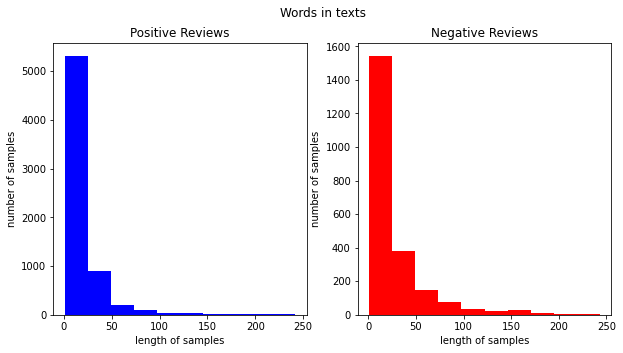

In [ ]:
# 긍정/부정 리뷰별 평균 길이 비교
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['sentiment']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['sentiment']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

# 각각의 X_train, y_rain, X_test, y_test에 직접 지정

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['sentiment'].values
X_test= test_data['tokenized'].values
y_test = test_data['sentiment'].values

# 단어 기반 인코딩
- 텍스트를 숫자로 처리하도록 training data, test data에 tokenizer 적용

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작을 때
  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6290
등장 빈도가 1번 이하인 희귀 단어의 수: 1513
단어 집합에서 희귀 단어의 비율: 24.054054054054056
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7877049308350297


In [ ]:
# 희귀 단어 제외 단어 집합 크기
# 0,1번 empty값, OOV 토큰 고려, +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4779


## 시퀀스로 변환

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[747, 8, 334, 247, 215, 14], [87, 6, 8, 48, 1, 147, 5, 2, 181, 7, 202, 197, 211, 4, 341, 90, 84, 51, 1200, 25, 6, 48], [317, 42, 23, 672, 4]]


In [ ]:
print(X_test[:3])

[[1299, 11, 1231, 84], [110, 7, 6, 22, 12, 30, 5], [681, 9, 542, 66, 5]]


## 리뷰 길이 조정을 위한 패딩

리뷰의 최대 길이 : 243
리뷰의 평균 길이 : 21.679119638826187


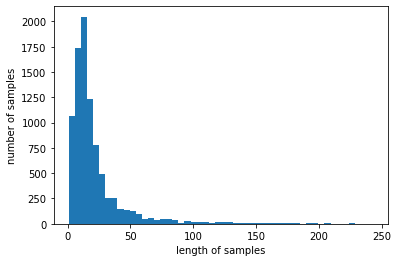

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 위의 그래프를 통해 60을 max_len으로 지정

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 94.28893905191875


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## X_train과 y_train -> train & validation dataset으로 나누기

In [ ]:
x_train_tmp, x_val, y_train_tmp, y_val = train_test_split(
    X_train, y_train, test_size=0.3, shuffle=True, stratify=y_train, random_state=20)

In [ ]:
x_train_tmp.shape, x_val.shape, y_train_tmp.shape, y_val.shape

((6202, 60), (2658, 60), (6202,), (2658,))

# LSTM과 클래스 가중치로 모델 학습
- 부정리뷰의 수와 긍정리뷰의 수의 균형을 맞추기 위해 **부정리뷰에 가중치 부여**

###Step 1. 클래스 가중치 계산

In [ ]:
neg, pos = np.bincount(labeled_df['sentiment'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 12658
    Positive: 9458 (74.72% of total)

Weight for class 0: 1.98
Weight for class 1: 0.67


###Step 2. 모델 구조 설계

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 64))
model.add(layers.Bidirectional(layers.LSTM(120)))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          305856    
                                                                 
 bidirectional (Bidirectiona  (None, 240)              177600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 241       
                                                                 
Total params: 483,697
Trainable params: 483,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

###Step 3. 모델에 필요한 설정 정보 세팅

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

###Step 4. 클래스 가중치로 모델 학습

In [ ]:
weighted_history = model.fit(x_train_tmp, y_train_tmp, 
                              epochs=15, 
                              callbacks=[es, mc],
                              batch_size=60,
                              validation_data= (x_val, y_val),
                              class_weight=class_weight)

Epoch 1/15
104/104 [==============================] - ETA: 0s - loss: 0.6491 - acc: 0.7048
Epoch 00001: val_acc improved from -inf to 0.76072, saving model to best_model.h5
104/104 [==============================] - 29s 216ms/step - loss: 0.6491 - acc: 0.7048 - val_loss: 0.5235 - val_acc: 0.7607
Epoch 2/15
104/104 [==============================] - ETA: 0s - loss: 0.5409 - acc: 0.7520
Epoch 00002: val_acc did not improve from 0.76072
104/104 [==============================] - 21s 206ms/step - loss: 0.5409 - acc: 0.7520 - val_loss: 0.5421 - val_acc: 0.7468
Epoch 3/15
104/104 [==============================] - ETA: 0s - loss: 0.5038 - acc: 0.7891
Epoch 00003: val_acc did not improve from 0.76072
104/104 [==============================] - 22s 215ms/step - loss: 0.5038 - acc: 0.7891 - val_loss: 0.5626 - val_acc: 0.7340
Epoch 4/15
104/104 [==============================] - ETA: 0s - loss: 0.4509 - acc: 0.8133
Epoch 00004: val_acc improved from 0.76072 to 0.76637, saving model to best_model.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n Best Model의 성능: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

119/119 [==============================] - 4s 26ms/step - loss: 0.5671 - acc: 0.7707

 Best Model의 성능: 0.7707


# 학습을 바탕으로 리뷰를 긍정과 부정으로 라벨링 시키기
- 새로운 텍스트로 분류시켜보기 위해 라벨링되지 않은 리뷰 데이터 불러오기

In [ ]:
# 어미 어근으로 분리된 리뷰 데이터 불러오기;
test_url = 'review1_token.xlsx'
new = pd.read_excel(test_url)

# 카피본만들기
unlabeled_df = new.copy()

In [ ]:
unlabeled_df.head()

,Unnamed: 0,Code,name,preprocessed_review,review,separate_review
0,0,0,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...
1,1,0,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠
2,2,0,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,13일 토요일에 새벽에 관리자분이 친절하셨
3,3,1,베스트인 시티 부산역,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았어요
4,4,1,베스트인 시티 부산역,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았


In [ ]:
# 결측값 확인 및 feature engineering
print(unlabeled_df.isnull().sum())
unlabeled_df = unlabeled_df.drop(['Unnamed: 0', 'Code', 'review'], axis=1)

Unnamed: 0             0
Code                   0
name                   0
preprocessed_review    0
review                 0
separate_review        0
dtype: int64


In [ ]:
# 긍정부정 라벨링으로 descending order로 분류해 재정렬하기 -> 나중에 stratify를 사용해 긍정과 부정의 비율을 맞추기 위함

# 인덱스 재조정
unlabeled_df = unlabeled_df.reset_index()

# 예전 인덱스 칼럼 드랍
unlabeled_df = unlabeled_df.drop(['index'], axis=1)

# 데이터프레임 카피본
unlabeled = unlabeled_df.copy()

In [ ]:
unlabeled

,name,preprocessed_review,separate_review
0,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...
1,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠
2,베스트인 시티 부산역,위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 1...,13일 토요일에 새벽에 관리자분이 친절하셨
3,베스트인 시티 부산역,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았어요
4,베스트인 시티 부산역,마사지도 너무 잘 받았고 숙박도 좋았어요,마사지도 너무 잘 받았고 숙박도 좋았
...,...,...,...
2621,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...
2622,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,잠만 자고 가기는 괜찮은 거 같
2623,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,좀 춥
2624,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,창가 옆은 온도 올렸는데 잘 안 올라가


In [ ]:
# 함수 생성
def weighted_predict(new_sentence):
  global score
  mec_sentence = mecab.morphs(new_sentence) #토큰화
  encoded = tokenizer.texts_to_sequences([mec_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{}. {} : {:.2f}% 확률로 긍정 리뷰입니다.".format(count, new_sentence, score * 100))
  else:
    #merged_df['sentiment'][count] = '부정'
    print("{}. {} : {:.2f}% 확률로 부정 리뷰입니다.".format(count, new_sentence, (1 - score) * 100))

In [ ]:
# separate_review에 함수 적용 -> 새로운 테스트 데이터에 긍정=1 부정=0 라벨링하기
unlabeled['sentiment']=0
count=0
for new_review in unlabeled['separate_review']:
  weighted_predict(new_review)
  unlabeled['sentiment'][count] = np.select([score > 0.5], ['1'], default='0')
  count+=1

0. 위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠어요 그리고 13일 토요일에 새벽에 관리자분이 친절하셨어요 : 89.07% 확률로 긍정 리뷰입니다.
1. 위치가 부산역이랑 가까워서 좋았는데 객실 청소가 조금 미흡해서 아쉬웠 : 66.23% 확률로 부정 리뷰입니다.
2.  13일 토요일에 새벽에 관리자분이 친절하셨 : 87.42% 확률로 긍정 리뷰입니다.
3. 마사지도 너무 잘 받았고 숙박도 좋았어요 : 77.62% 확률로 긍정 리뷰입니다.
4. 마사지도 너무 잘 받았고 숙박도 좋았 : 62.44% 확률로 긍정 리뷰입니다.
5. 부산 출장 시 항상 숙박하는 곳입니다 구성비  좋아요 : 52.69% 확률로 긍정 리뷰입니다.
6. 초량역에서 정말 가깝습니다 그리고 타이마사지도 시원하게 잘 받았습니다 다만 밤에 예약이 몰려있어 이용하실 거면 미리 말씀드려야 합니다 직원분들 서비스도 괜찮았고요 다만 객실 내 창틀이나 구석진 곳에 먼지가 쌓여있었고 세면대 배수구 쪽이 녹이 슬어있어서 조금 아쉬웠습니다 그리고 저희 일행은 계속 돌아다녔는데 모기는 어디서 들어온 건지 모기 때문에 밤잠은 조금 설쳤네요  : 98.53% 확률로 부정 리뷰입니다.
7. 초량역에서 정말 가깝 : 77.18% 확률로 긍정 리뷰입니다.
8.  타이마사지도 시원하게 잘 받았 : 56.94% 확률로 긍정 리뷰입니다.
9.  밤에 예약이 몰려있어 이용하실 거면 미리 말씀드려야 합니다 직원분들 서비스도 괜찮았 : 94.92% 확률로 긍정 리뷰입니다.
10.  객실 내 창틀이나 구석진 곳에 먼지가 쌓여있었고 세면대 배수구 쪽이 녹이 슬어있어서 조금 아쉬웠 : 93.26% 확률로 부정 리뷰입니다.
11.  저희 일행은 계속 돌아다녔는데 모기는 어디서 들어온 건지 모기 때문에 밤잠은 조금 설쳤네요  : 98.34% 확률로 부정 리뷰입니다.
12. 객실에서 냄새 담배가 지독히 납니다 최소한의 객실 관리가  전혀 안되고 있었니 다시는 묵고 싶은 생각이 없습니다 : 96.67% 확률로 부정 리

In [ ]:
# 긍정이면 df의 새로운 칼럼(sentiment) 생성 후, 1 (긍정), 0 (부정) 추가
unlabeled[1200:]

,name,preprocessed_review,separate_review,sentiment
1200,해운대 소사이어티 호텔,깨끗하고 깔끔했어요 조식도 나름 괜찮았어요 잘 쉬다 갑니다,깨끗하고 깔끔했어요 조식도 나름 괜찮았어요 잘 쉬다 갑니다,1
1201,해운대 소사이어티 호텔,깨끗하고 깔끔했어요 조식도 나름 괜찮았어요 잘 쉬다 갑니다,깨끗하고 깔끔했,1
1202,해운대 소사이어티 호텔,깨끗하고 깔끔했어요 조식도 나름 괜찮았어요 잘 쉬다 갑니다,조식도 나름 괜찮았,1
1203,해운대 소사이어티 호텔,지은 지 얼마 안 돼서 그런지 새것 냄새가 났지만 청결하고 깔끔하여서 너무 좋았습니...,잘 쉬다 갑니다,0
1204,해운대 소사이어티 호텔,지은 지 얼마 안 돼서 그런지 새것 냄새가 났지만 청결하고 깔끔하여서 너무 좋았습니...,지은 지 얼마 안 돼서 그런지 새것 냄새가 났지만 청결하고 깔끔하여서 너무 좋았습니...,0
...,...,...,...,...
2621,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,0
2622,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,잠만 자고 가기는 괜찮은 거 같,0
2623,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,좀 춥,1
2624,마리안느호텔,잠만 자고 가기는 괜찮은 거 같아요 근데 좀 춥더라고요 창가 옆은 온도 올렸는데 잘...,창가 옆은 온도 올렸는데 잘 안 올라가,0


###Step 5. 학습 모델 분류 평가

In [ ]:
train_predictions_weighted = model.predict(x_train_tmp, batch_size=60)
test_predictions_weighted = model.predict(X_test, batch_size=60)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

###train data에 대한 Confusion Matrix

True Negatives:  1250
False Positives:  318
False Negatives:  415
True Positives:  4219


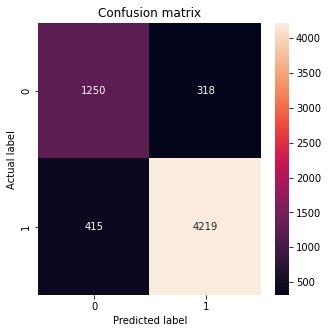

In [ ]:
plot_cm(y_train_tmp, train_predictions_weighted)

###test data에 대한 Confusion Matrix

True Negatives:  533
False Positives:  427
False Negatives:  444
True Positives:  2394


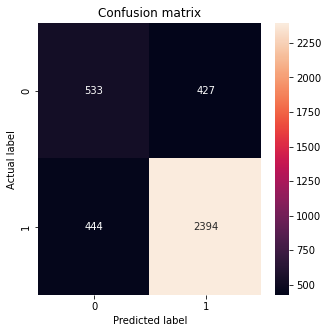

In [ ]:
plot_cm(y_test, test_predictions_weighted)